In [2]:
import sys
print('python', sys.version)

import numpy as np
print('numpy', np.__version__)

import pandas as pd
print('pandas', pd.__version__)

import matplotlib as mpl
print('matplotlib', mpl.__version__)
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sci
import glob
import networkx as nx
#import Bio.KEGG.KGML.KGML_parser as keg

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import gseapy as gp

python 3.11.3 | packaged by Anaconda, Inc. | (main, Apr 19 2023, 23:46:34) [MSC v.1916 64 bit (AMD64)]
numpy 1.24.3
pandas 1.5.3
matplotlib 3.7.1


In [3]:
lib_list=gp.get_library_name(organism='Human')
lib_list

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 'Descartes_Cell_Types_and_Tissue_2021',
 'Diabetes_Perturbations_GEO_2022',
 'DisGeNET',
 'Disease_

In [3]:
lib_list=['DSigDB',
 'DisGeNET',
 'GO_Biological_Process_2023',
 'GO_Molecular_Function_2023',
 'GeneSigDB',
 'KEGG_2021_Human',
 'Reactome_2022',
 'WikiPathway_2021_Human',
 'dbGaP']

## previous version (0813)

In [4]:
all_nsig_df=pickle.load(open("../n_stage_pred_BRCA_0804toPC/main_result/BRCA_sig_info.pickle", 'rb'))
all_nsig_df

res_df_save=pd.DataFrame(columns=['epval', 'Term', 'P-value', 'Adjusted P-value', 'Genes'])
res_df_vis=pd.DataFrame()
for epval in [0.001, 0.005, 0.01]:
    MG_genes=all_nsig_df.loc[epval,'sig_genes']
    len(MG_genes)
    enr = gp.enrichr(gene_list=MG_genes,
                     gene_sets=['DisGeNET'],
                     organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                     outdir=None) # don't write to disk
                    
    df1=enr.results
    df1=df1.loc[df1['Term'].isin(['Invasive carcinoma of breast',
                                  'Infiltrating duct carcinoma of female breast'])]
    ####
    df2=df1.copy()
    df2['Term']=df2['Term'].map(lambda x: 'EP{} on <{}>'.format(epval, x))
    res_df_vis=pd.concat([res_df_vis, df2])
    ####
    
    df1=df1[['Term', 'P-value', 'Adjusted P-value', 'Genes']].copy()
    df1['epval']=epval
    df1=df1[['epval','Term', 'P-value', 'Adjusted P-value', 'Genes']]
    res_df_save=pd.concat([res_df_save, df1])
    
res_df_save['Genes']=res_df_save['Genes'].str.replace(';','_')
res_df_save=res_df_save.reset_index(drop=True)[['epval','Term','P-value','Genes']].rename(columns={'Term': 'DisGeNET term', 'Genes': 'shared genes'})
res_df_save.to_csv('../n_stage_pred_BRCA_0804toPC/main_result/GSEA_DisGeNet.txt', sep='\t')

,num_of_sig,sig_genes
0.001,54,"[BTBD8, PTGS2, SH3BGRL, GSTM5, TMPRSS5, KRT4, ..."
0.005,202,"[EGLN2, GRB7, ELAVL1, CLDN4, KCNJ3, CCDC93, WN..."
0.010,357,"[UNC93B1, PLGLB2, GRB7, WNT7A, TSKS, CCDC60, T..."


54

202

357

In [5]:
res_df_save

,epval,DisGeNET term,P-value,shared genes
0,0.001,Invasive carcinoma of breast,0.020083,GRB7_IRF1_TNFRSF11A_PTGS2
1,0.005,Infiltrating duct carcinoma of female breast,0.001357,CAMK1G_CDK15_FGFR1
2,0.005,Invasive carcinoma of breast,0.005926,GRB7_IRF1_F2R_FAT1_THRSP_TNFRSF11A_NLRP1_PTGS2...
3,0.010,Invasive carcinoma of breast,0.001614,GRB7_HDAC1_F2R_TSC2_TNFRSF11A_PTGS2_HSD17B7_MM...
4,0.010,Infiltrating duct carcinoma of female breast,0.006752,CAMK1G_CDK15_FGFR1


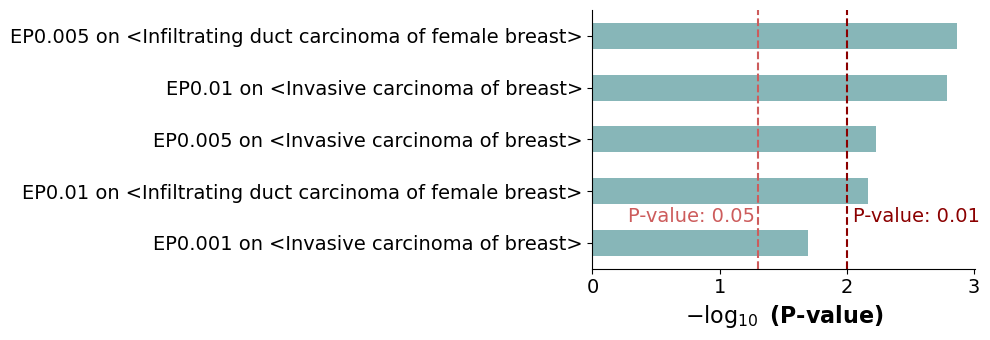

In [6]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
                 
from gseapy import barplot, dotplot
# categorical scatterplot
ax = barplot(res_df_vis,
             column="P-value",
             #group='Gene_set', # set group, so you could do a multi-sample/library comparsion
             cutoff=1,
             size=20,
             top_term=20,
             figsize=(10,3.5),
             dpi=200,
             color=['cadetblue'] # set colors for group
             )

_=ax.set_xlabel(ax.get_xlabel(), fontsize=16)
_=ax.tick_params(axis='both', labelsize=14)
_=ax.axvline(-np.log10(0.01), color='darkred', linestyle='--')
_=ax.text(-np.log10(0.009), 0.5, 'P-value: 0.01', va='center', ha='left', color='darkred', fontsize=14)
_=ax.axvline(-np.log10(0.05), color='indianred', linestyle='--')
_=ax.text(-np.log10(0.053), 0.5, 'P-value: 0.05', va='center', ha='right', color='indianred', fontsize=14)

#_=ax.text(-3, 8, 'Enrichment test on metastatic terms\nreported in DisGeNET database', fontsize=22)


#fig.subplots_adjust(left=0.5, bottom=2, right=0.6, top=2.1, wspace=2, hspace=2)
plt.savefig('../n_stage_pred_BRCA_0804toPC/main_result/GSEA_DisGeNet.jpg', dpi=200)